# Health Inspection Scores for San Francisco Restaurants

Exploring the contents from a SQLite database containing health inspection scores for restaurants around San Francisco.  They take place between October 2013 to October 2015.

Source: [San Francisco Restaurant Health Inspections](http://2016.padjo.org/tutorials/sqlite-data-starterpacks/#toc-san-francisco-restaurant-health-inspections)

## Setting up

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Creating a function that takes a SQL query as an argument
# and returns a pandas dataframe of that query. 

def run_query(q):
    with sqlite3.connect('sfscores.sqlite') as conn:
        return pd.read_sql(q, conn)
    
# Creating a function that takes a SQL command as an argument 
# and executes it using the sqlite module

def run_command(c):
    with sqlite3.connect('sfscores.sqlite') as conn:
        conn.isolation_level = None
        conn.execute(c)

# Creating a function that calls the run_query() function to return a 
# list of all tables and views in the database

def show_tables():
    st = "SELECT name, type FROM sqlite_master WHERE type IN (\"table\",\"view\");"
    return run_query(st)
    
show_tables()


,name,type
0,businesses,table
1,inspections,table
2,chains,table
3,violations,table


In [2]:
# Checking the content of businesses table

b_query = "SELECT * FROM businesses ORDER BY RANDOM() LIMIT 3"

run_query(b_query)

,business_id,name,address,city,postal_code,latitude,longitude,phone_number,TaxCode,business_certificate,application_date,owner_name,owner_address,owner_city,owner_state,owner_zip
0,65463,La Cocina,1 Ferry Building #50,None,94111,NaN,NaN,None,H34,NaN,2010-01-12,"La Cocina, Inc. / Caleb Zigas, Matt Skov",2948 Folsom Street,San Francisco,CA,94110
1,2987,The Penthouse Club & Steakhouse,412 Broadway St,San Francisco,94133,37.798217,-122.404214,None,H26,329590.0,None,"Alternative Entertainment, Inc",412 Broadway St,San Francisco,CA,94133
2,4592,E-Z STOP MARKET,2203 GENEVA Ave,S.F.,94134,37.708356,-122.419989,None,H28,927552.0,1994-02-16,MAHMOND A. ELMIAARI,544 3RD AVE.,SAN BRUNO,CA,94066


In [3]:
# Checking the content of inspections table

i_query = "SELECT * FROM inspections ORDER BY RANDOM() LIMIT 3"

run_query(i_query)

,business_id,Score,date,type
0,62578,NaN,20140725,Complaint
1,81453,98.0,20160801,Routine - Unscheduled
2,5631,NaN,20150920,Reinspection/Followup


In [4]:
# Checking the content of violations table

v_query = "SELECT * FROM violations ORDER BY RANDOM() LIMIT 3"

run_query(v_query)

,business_id,year_month,date,ViolationTypeID,risk_category,description
0,3859,20140501,20140522,103120,Moderate Risk,Moderate risk food holding temperature
1,2109,20150501,20150528,103132,Moderate Risk,Improper thawing methods
2,3029,20160301,20160314,103116,Moderate Risk,Inadequate food safety knowledge or lack of ce...


## Exploratory queries

Examining the contents of the inspections database.

First, a list of the top 10 restaurants with the most high risk violations.

In [5]:
top10_violations_query = """

SELECT b.name, b.address, COUNT(1) num_violations
FROM businesses b
INNER JOIN violations v ON b.business_id = v.business_id
GROUP BY b.business_id
HAVING v.risk_category = "High Risk"
ORDER BY num_violations DESC
LIMIT 10
"""

run_query(top10_violations_query)

,name,address,num_violations
0,Hakka Restaurant,4401 A Cabrillo St Suite A,42
1,Hong Kong Lounge,5322 Geary Blvd,36
2,PACIFIC SUPER MARKET,2900 ALEMANY Blvd,34
3,Mission's Kitchen,2738 Mission St,34
4,El Nuevo Porvenir,2950 21st St,32
5,Cafe Bakery,1345 Noriega St,31
6,Taqueria Castillo B,10 Mason St,31
7,The AA Bakery & Cafe,1068 Stockton St,30
8,BASIL THAI RESTAURANT & BAR,1175 FOLSOM St,30
9,Jade Garden,3608 BALBOA St,28


Next, a look at the top 10 locations with the most high risk violations per inspection

In [6]:
# Returning the top 10 locations with the most violations per inspection

top10_avg_violations_query = """

WITH total_violations as (
    SELECT b.business_id, COUNT(1) num_violations
    FROM businesses b
    INNER JOIN violations v ON b.business_id = v.business_id
    GROUP BY b.business_id
    HAVING v.risk_category = "High Risk"
), total_inspections as (
    SELECT b.business_id, COUNT(1) num_inspections
    FROM businesses b
    INNER JOIN inspections i ON b.business_id = i.business_id
    GROUP BY b.business_id
)

SELECT b.business_id, b.name, b.address, ROUND((CAST(tv.num_violations as Float)/CAST(ti.num_inspections
                     as float)), 2) avg_violations
FROM businesses b
INNER JOIN total_violations tv ON b.business_id = tv.business_id
INNER JOIN total_inspections ti ON b.business_id = ti.business_id
GROUP BY b.business_id
ORDER BY avg_violations DESC
LIMIT 10
"""

run_query(top10_avg_violations_query)

,business_id,name,address,avg_violations
0,62462,Gateway Croissants,390 GOLDEN GATE Ave,7.00
1,62330,Social Kitchen & Brewery,1326 09th Ave,6.00
2,80643,Taqueria El Castillito,370 Golden Gate Ave,6.00
3,26348,Won Mi Restaurant,1545 Fillmore St,5.00
4,68245,U-Sushi,525 Market St Ste. 130,5.00
5,68320,Newtree,16 Jessie St,5.00
6,76513,Archive Bar & Kitchen,602 Mission St,5.00
7,78295,Perilla,510 Mission St,5.00
8,320,NAPOLI PIZZA RESTAURANT,1045 POLK St,4.80
9,69486,Tsing's Chinese Restaurant,361 WEST PORTAL Ave,4.67


Finally, the 10 restaurants with the worst average scores.

In [7]:
# Returning restaurants with the lowest average inspections scores

worst10_scores_query = """

SELECT b.name, b.address, AVG(i.Score) Average_Score
FROM businesses b
INNER JOIN inspections i ON b.business_id = i.business_id
GROUP BY b.business_id
HAVING i.Score IS NOT NULL
ORDER BY Average_Score
LIMIT 10
"""

run_query(worst10_scores_query)

,name,address,Average_Score
0,Harbor Villa Restaurant,5238 Diamond Heights Blvd,55.000000
1,Thai 4 You,807 Ellis St,59.000000
2,New Asia Restaurant,772 Pacific Ave,60.500000
3,THEM KY RESTAURANT,717 ELLIS St,61.500000
4,Rumors,398 07th St,64.000000
5,Imperial Palace,818 Washington St,64.333333
6,"Sunmoon Market, Inc.",638 Broadway St,65.000000
7,The Supremo Pizza LLC,87 06th St,66.000000
8,GAS & SHOP,599 South Van Ness Ave,66.500000
9,Tsing's Chinese Restaurant,361 WEST PORTAL Ave,66.500000


## Modifying Tables

Displaying the number of violations for every month recorded in the database. 

In [8]:
# Returning the number of violations per Month-Year combination

new_violations = """

CREATE TABLE IF NOT EXISTS violations_dates (
business_id TEXT, year_month TEXT, date TEXT, ViolationTypeID TEXT, risk_category TEXT, description TEXT
);

"""

insert_violations = """

INSERT INTO violations_dates
SELECT business_id, SUBSTR(date,1,6)|| '01', date, ViolationTypeID, risk_category, description
FROM violations;

"""

run_command(new_violations)
run_command(insert_violations)
run_command("DROP TABLE IF EXISTS violations;")
run_command("ALTER TABLE violations_dates RENAME TO violations;") 

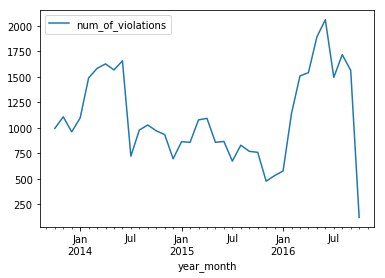

In [9]:
test_query = "SELECT * FROM inspection_dates LIMIT 15"

test_query2 = "PRAGMA table_info(violations);"

test_query3 = """

SELECT year_month, COUNT(1) num_of_violations
FROM violations
GROUP BY year_month
ORDER BY year_month

"""

violations_month = run_query(test_query3)
violations_month['year_month'] = pd.to_datetime(violations_month['year_month'], yearfirst=True)
violations_month.plot.line(x='year_month',y='num_of_violations')